# Epiretinal Model Fitting Notebook

Contains code for Beyeler2019 like evaluation based on area, eccentricity, and orientation, as well as Granley2021 like evaluation for scaling amplitude, frequency, and pulse duration on data from Nanduri2012, Weitz2015, Horsanger2009, and Greenwald2009.
Beyeler code currently does not use leave on electrode out cross validation. It is just for evaluating

## Setup Code

In [ ]:
import shapes
import pulse2percept as p2p
from pulse2percept.stimuli import BiphasicPulseTrain
from pulse2percept.implants import ArgusII
from pulse2percept.utils import center_image, r2_score, circ_r2_score
from pulse2percept.models import AxonMapModel, BiphasicAxonMapModel, Nanduri2012Model
from pulse2percept.stimuli import BiphasicPulseTrain, Stimulus
from pulse2percept.implants import DiskElectrode, ProsthesisSystem, ArgusI
from pulse2percept.datasets import load_nanduri2012
from skimage import measure
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
h5_shapes = "/home/jgranley/shapes/data/shapes.h5"
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [2]:
### Helper class and functions to aggregate and plot results ###
class RegressionResults:
    def __init__(self, model=None, implant=None, name=None, subject=None):
        self.subject = subject
        self.model = model
        self.implant = implant
        self.name = name
        if self.name is None:
            self.name = str(model.__class__.__name__)
        
        # results (score or metric)
        self.results = {}
        # data on predictions vs true
        self.data = {}
        # any parameters used for the evaluation
        self.params = {}
        
    def add_results(self, runname, results, data, params):
        self.results[runname] = results
        self.data[runname] = data
        self.params[runname] = params
        
        
def plot_beyeler_percepts(results, vmax=1, annotate=True):
    """ assumes all results objects use the same data """
    if not isinstance(results, list):
        results = [results]
    runname = 'beyeler2019'
    for r in results:
        if runname not in r.data:
            raise ValueError()
    elecs = results[0].data[runname]['elecs']
    nrows = len(results) + 1
    ncols = results[0].data[runname]['elecs']
    ncols = min(len(elecs), 10)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    
    plotdata = [results[0].data[runname]['true']] + [r.data[runname]['preds'] for r in results]
    titles = ['True'] + [r.name for r in results]
    for idx_col in range(ncols):
        true_prop = plotdata[0]['props'][idx_col]
        for idx_row in range(nrows):
            ax = axes[idx_row, idx_col]
            plt.sca(ax)
            img = plotdata[idx_row]['percepts'][idx_col]
            if isinstance(img, p2p.percepts.Percept):
                img = img.max(axis='frames')
                img = p2p.utils.center_image(img)
            plt.imshow(img, cmap='gray', vmax=vmax)
            if idx_row == 0:
                plt.title(elecs[idx_col])
            if idx_col == 0:
                # electrode
                plt.ylabel(titles[idx_row])
            if annotate and idx_row == 0:
                plt.xlabel(f"a:{true_prop[0]:.0f} e:{true_prop[1]:.2f} o:{true_prop[2]:.2f}")
            elif annotate:
                diff = (plotdata[idx_row]['props'][idx_col] - true_prop) / true_prop * 100
                plt.xlabel(rf"$\Delta$ a:{diff[0]:.0f}% e:{diff[1]:.0f}% o:{diff[2]:.0f}%")
            ax.set_yticks([])
            ax.set_xticks([])
            ax.spines['bottom'].set_color('gray')
            ax.spines['top'].set_color('gray')
            ax.spines['right'].set_color('gray')
            ax.spines['left'].set_color('gray')
            ax.spines['bottom'].set_linewidth(1)
            ax.spines['top'].set_linewidth(1)
            ax.spines['right'].set_linewidth(1)
            ax.spines['left'].set_linewidth(1)
    plt.subplots_adjust(hspace=0, wspace=0)
    fig.suptitle("Scores: " + str([f"{r.results[runname]['score'] : .1f}" for r in results])) 
    # return fig
            
def plot_beyeler_props(results):
    if not isinstance(results, list):
        results = [results]
    nrows = len(results)
    ncols = 3
    names = ['Area', 'Eccentricity', 'Orientation']
    runname = 'beyeler2019'
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    for idx_row in range(nrows):
        for idx_col in range(ncols):
            if nrows > 1:
                ax = axes[idx_row, idx_col]
            else:
                ax = axes[idx_col]
            plt.sca(ax)
            res = results[idx_row].data[runname]
            true = res['true']['props']
            pred = res['preds']['props']
            p2p.viz.scatter_correlation(pred[:, idx_col], true[:, idx_col], show_slope_intercept=True, ax=ax)
            if idx_row == 0:
                plt.title(names[idx_col])
            if idx_col == 0:
                ylabel = results[idx_row].name + "\n"
            else:
                ylabel = ''
            ylabel += 'True'
            plt.ylabel(ylabel)
            plt.xlabel("Predicted")

            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            lim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
            plt.xlim(lim)
            plt.ylim(lim)
            plt.plot(lim, lim, linestyle=':', color='gray')

In [103]:
##### Beyeler 2019 evaluation #####           
def beyeler2019_eval(subject, implant, model, test_amps=[2.], data=None, resultsObj=None, thresh=1/np.exp(1)**2, dofit=False):
    """
    Returns:
    RegressionResults object
    """
    runname = 'beyeler2019'
    img_shape = None
    if data is None:
        data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
    data = data[data.subject == subject]
    if test_amps is not None:
        data = data[data.amp1.isin(test_amps)]
    if not model.is_built:
        model.build()
    results = resultsObj
    if results is None:
        results = RegressionResults(model=model, implant=implant, subject=subject)
    elecs = data.electrode1.unique()
    
    # fit model if applicable
    if dofit and hasattr(model, 'fit') and callable(model.fit):
        model.fit(data)
    
    def get_prop(img):
        props = measure.regionprops(measure.label(img > thresh))
        class empty_prop:
            def __init__(self):
                self.area = -1
                self.orientation=-1
                self.eccentricity=-1
        if len(props) == 0:
            return empty_prop()
        return max(props, key = lambda x : x.area)
    
    true = {'percepts':[], 'props':[]}
    pred = {'percepts':[], 'props':[]}
    tot_time = 0
    for idx_elec, elec in enumerate(elecs):
        dfelec = data[data.electrode1 == elec]
        
        ## True
        # try:
        true_perc = center_image(shapes.stack_phosphenes(dfelec).combined_image.iloc[0])
        # except:
        #     true_perc = np.zeros_like(dfelec['image'].iloc[0])
        
        true['percepts'].append(true_perc)
        # need to average props from each trial, not props from averaged percept
        trial_props = []
        
        for image in dfelec.image:
            if img_shape is None:
                img_shape = image.shape
            if image.shape != img_shape:
                image = resize(image, img_shape)
            prop = get_prop(image)
            trial_props.append([prop.area, prop.eccentricity, prop.orientation])
        true['props'].append(np.mean(trial_props, axis=0))
        
        ## Predicted
        stim = {elec : BiphasicPulseTrain(dfelec.freq.iloc[0], dfelec.amp1.iloc[0], dfelec.pdur.iloc[0])}
        implant.stim = stim
        if isinstance(model, p2p.models.AxonMapModel) or isinstance(model, p2p.models.ScoreboardModel):
            # axonmap tries to evaluate at every time point
            implant.stim = {elec : dfelec.amp1.iloc[0]}
        start = time.time()
        pred_perc = model.predict_percept(implant)
        tot_time += time.time() - start
        pred['percepts'].append(pred_perc)
        # print(elec, pred_perc.shape, img_shape)
        # print(np.sum(pred_perc.max(axis='frames') > 1 / np.exp(1)**2))
        # print(np.sum(resize(pred_perc.max(axis='frames'), img_shape) > 1 / np.exp(1)**2))
        prop = get_prop(resize(pred_perc.max(axis='frames'), img_shape))
        
        pred['props'].append([prop.area, prop.eccentricity, prop.orientation])
        
    true['percepts'] = np.array(true['percepts'])
    true['props'] = np.array(true['props'])
    pred['percepts'] = np.array(pred['percepts'])
    pred['props'] = np.array(pred['props'])
    
    r2_scores = np.array([r2_score(true['props'][:, i], pred['props'][:, i]) for i in [0, 1]] + [circ_r2_score(true['props'][:, 2], pred['props'][:, 2])])
    score = 1 - np.sum(r2_scores)
    
    res = {'score':score, 'r2_scores':r2_scores, 'time':tot_time}
    dat = {'true':true, 'preds':pred, 'elecs':elecs}
    runparams = {'test_amps':test_amps, 'thresh':thresh}
    results.add_results(runname, res, dat, runparams)
    
    return results

In [ ]:
def granley2021_eval(implant, model, data=None, resultsObj=None, thresh=1/np.exp(1)**2, dofit=False):
    """
    Evaluation from granley 2021, including eval from nanduri2012 data and greenwald 2009 data
    data should be tuple of (nanduri_data, greenwald_data)
    Returns:
    RegressionResults object
    """
    
    img_shape = None
    if data is None:
        data_nanduri = load_nanduri2012()
        data_greenwald = pd.read_csv("/home/jgranley/shapes/data/greenwald.csv")
    else:
        data_nanduri = data[0]
        data_greenwald = data[1]

    if not model.is_built:
        model.build()
    results = resultsObj
    if results is None:
        results = RegressionResults(model=model, implant=implant, subject=subject)
    elecs = data.electrode1.unique()
    
    # fit model if applicable
    if dofit and hasattr(model, 'fit') and callable(model.fit):
        model.fit(data)
        
    ### Nanduri ###
    nanduri_ampvbright(model, data_nanduri, results)
    nanduri_freqvbright(model, data_nanduri, results)
    nanduri_ampvsize(model, results, thresh)
    ### Greenwald ###
    greenwald_eval(model, results)
    
    
    

In [ ]:
def nanduri_ampvbright(model, df, results):
    runname = 'nanduri2012_ampvbright'

    df = df[(df['task'] == 'rate') & (df['varied_param'] == 'amp')]

    uniq_amps = np.unique(df['amp_factor'])
    avg_bright = [np.mean(df[df['amp_factor'] == a]['brightness']) for a in uniq_amps]
    std_bright = [np.std(df[df['amp_factor'] == a]['brightness']) / np.sqrt(np.size(df[df['amp_factor'] == a]['brightness'])) for a in uniq_amps]

    implant = ProsthesisSystem(DiskElectrode(0, 0, 0, 260))
    ref_stim = BiphasicPulseTrain(20, 1.25, 0.45, stim_dur=500)
    if isinstance(model, Nanduri2012Model):
        ref_stim = BiphasicPulseTrain(20, 1.25*30, 0.45, stim_dur=500)
    implant.stim = ref_stim
    ref_bright = model.predict_percept(implant).data.max()

    brights = []
    for amp in uniq_amps:
        if isinstance(model, Nanduri2012Model):
            amp *= 30
        stim = BiphasicPulseTrain(20, amp, 0.45, stim_dur=500)
        implant.stim = stim
        brights.append(model.predict_percept(implant).data.max() / ref_bright * 10)


    mse = np.mean((np.array(brights) - np.array(avg_bright))**2)
    r2 = r2_score(avg_bright, brights)

    res = {'mse' : mse, 'r2':r2}
    dat = {'true' : {'amps': uniq_amps, 'bright':avg_bright, 'bright_sem':std_bright},
           'preds': {'bright' : brights}}
    results.add_results(runname, res, dat, None)
    

def nanduri_freqvbright(model, df, results):
    runname = 'nanduri2012_freqvbright'

    df = df[(df['task'] == 'rate') & (df['varied_param'] == 'freq')]

    uniq_freqs = np.unique(df['freq'])
    avg_bright = [np.mean(df[df['freq'] == f]['brightness']) for f in uniq_freqs]
    std_bright = [np.std(df[df['freq'] == f]['brightness']) / np.sqrt(np.size(df[df['freq'] == f]['brightness'])) for f in uniq_freqs]

    implant = ProsthesisSystem(DiskElectrode(0, 0, 0, 260))
    
    ref_stim = BiphasicPulseTrain(20, 1.25, 0.45, stim_dur=500)
    if isinstance(model, Nanduri2012Model):
        ref_stim = BiphasicPulseTrain(20, 1.25*30, 0.45, stim_dur=500)
    implant.stim = ref_stim
    ref_bright = model.predict_percept(implant).data.max()


    brights = []
    for freq in uniq_freqs:
        amp = 1.25
        if isinstance(model, Nanduri2012Model):
            amp = *= 30
        stim = BiphasicPulseTrain(freq, amp, 0.45, stim_dur=500)
        implant.stim = stim
        brights.append(model.predict_percept(implant).data.max() / ref_bright * 10)




    mse = np.mean((np.array(brights) - np.array(avg_bright))**2)
    r2 = r2_score(avg_bright, brights)
    res = {'mse' : mse, 'r2':r2}
    dat = {'true' : {'freqs': uniq_freqs, 'bright':avg_bright, 'bright_sem':std_bright},
           'preds': {'bright' : brights}}
    results.add_results(runname, res, dat, None)
    

def nanduri_ampvsize(model, results, thresh):
    runname = 'nanduri2012_ampvsize'
    
    ##################################################################################################
    # taken from nanduri fig 8
    ampmod_ba = np.array([[10.042, 0.972], [11.333, 1.128],[14.125, 1.128],[15.917, 3.799],[19.000, 6.447]])

    ampmod_amps = [1.25, 1.5, 2, 4, 6]
    ampmod_freq = 20
    sems = [0.093, 0.095, 0.108, 0.682, 0.675]
    
    implant = ProsthesisSystem(DiskElectrode(0, 0, 0, 260))
    def get_size(percept, ref_bright=None):
        if ref_bright is None:
            ref_bright = (percept.max(axis='frames').max() - percept.max(axis='frames').min()) * 0.1 + percept.max(axis='frames').min()
        return (percept.max(axis='frames') > ref_bright).sum()

    # threshold_stim = BiphasicPulseTrain(20, 30, 0.45, stim_dur=500)
    # implant.stim = threshold_stim
    # bright_th = model.predict_percept(implant).get_brightest_frame().max()
    
    ref_stim = BiphasicPulseTrain(20, 1.25, 0.45, stim_dur=500)
    if isinstance(model, Nanduri2012Model):
        ref_stim = BiphasicPulseTrain(20, 1.25*30, 0.45, stim_dur=500)
    implant.stim = ref_stim
    ref_size = get_size(model.predict_percept(implant), ref_bright=thresh)

    sizes = []
    for amp in ampmod_amps:
        if isinstance(model, Nanduri2012Model):
            amp *= 30
        stim = BiphasicPulseTrain(20, amp, 0.45, stim_dur=500)
        implant.stim = stim
        sizes.append(get_size(model.predict_percept(implant), ref_bright=bright_th_nan) / ref_size )

    mse = np.mean((np.array(sizes) - np.array(ampmod_ba)[:, 1])**2)
    r2 = r2_score(np.array(ampmod_ba)[:, 1], sizes)
    
    res = {'mse' : mse, 'r2':r2}
    dat = {'true' : {'amps': ampmod_amps, 'size':ampmod_ba[:, 1], 'size_sem':sems},
           'preds': {'size' : sizes}}
    results.add_results(runname, res, dat, {'thresh':thresh})
    
def greenwald_eval(model, result, df):
    # df = df[df['subject'] == 'S05']
    threshs = df['threshold']
    amps = df['amp']
    brights = df['brightness']
    amp_factors = np.array(amps) / np.array(threshs)
    implant = ProsthesisSystem(DiskElectrode(0, 0, 0, 260))

    model_brights = []
    for i, amp, amp_factor, thresh, b in zip([i for i in range(len(amps))], amps, amp_factors, threshs, brights):
        ref_stim = BiphasicPulseTrain(1, 2.5, 0.975)
        if isinstance(model, Nanduri2012Model):
            ref_stim = BiphasicPulseTrain(1, 2.5*thresh, 0.975)
        implant.stim = ref_stim
        ref_bright = model.predict_percept(implant).data.max()

        stim = BiphasicPulseTrain(1, amp_factor, 0.975)
        if isinstance(model, Nanduri2012Model):
            stim = BiphasicPulseTrain(1, amp, 0.975)
        implant.stim=stim
        bright = model.predict_percept(implant).data.max()
        model_brights.append(bright / ref_bright * 10)

    mse = np.mean((np.array(model_brights) - np.array(brights))**2)
    r2 = r2_score(brights, model_brights)

    res = {'mse' : mse, 'r2':r2}
    dat = {'true' : {'amps': amp_factors, 'bright':brights},
           'preds': {'bright' : model_brights}}
    results.add_results(runname, res, dat, None)

## AxonMapModel

In [93]:
subject = '12-005'
implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
model.build()

AxonMapModel(ax_segments_range=(0, 50), axlambda=446, 
             axon_pickle='axons.pickle', 
             axons_range=(-180, 180), engine=None, 
             eye='RE', grid_type='rectangular', 
             ignore_pickle=False, loc_od=(15.8, 1.4), 
             min_ax_sensitivity=0.001, n_ax_segments=500, 
             n_axons=1000, n_gray=None, n_jobs=1, 
             n_threads=24, noise=None, 
             retinotopy=Watson2014Map, rho=120, 
             scheduler='threading', spatial=AxonMapSpatial, 
             temporal=None, thresh_percept=0, verbose=True, 
             xrange=(-30, 30), xystep=0.25, 
             yrange=(-22.5, 22.5))

{'beyeler2019': {'score': 4.462983131408691, 'r2_scores': array([-0.44 , -1.327,  0.304]), 'time': 0.5607664585113525}}


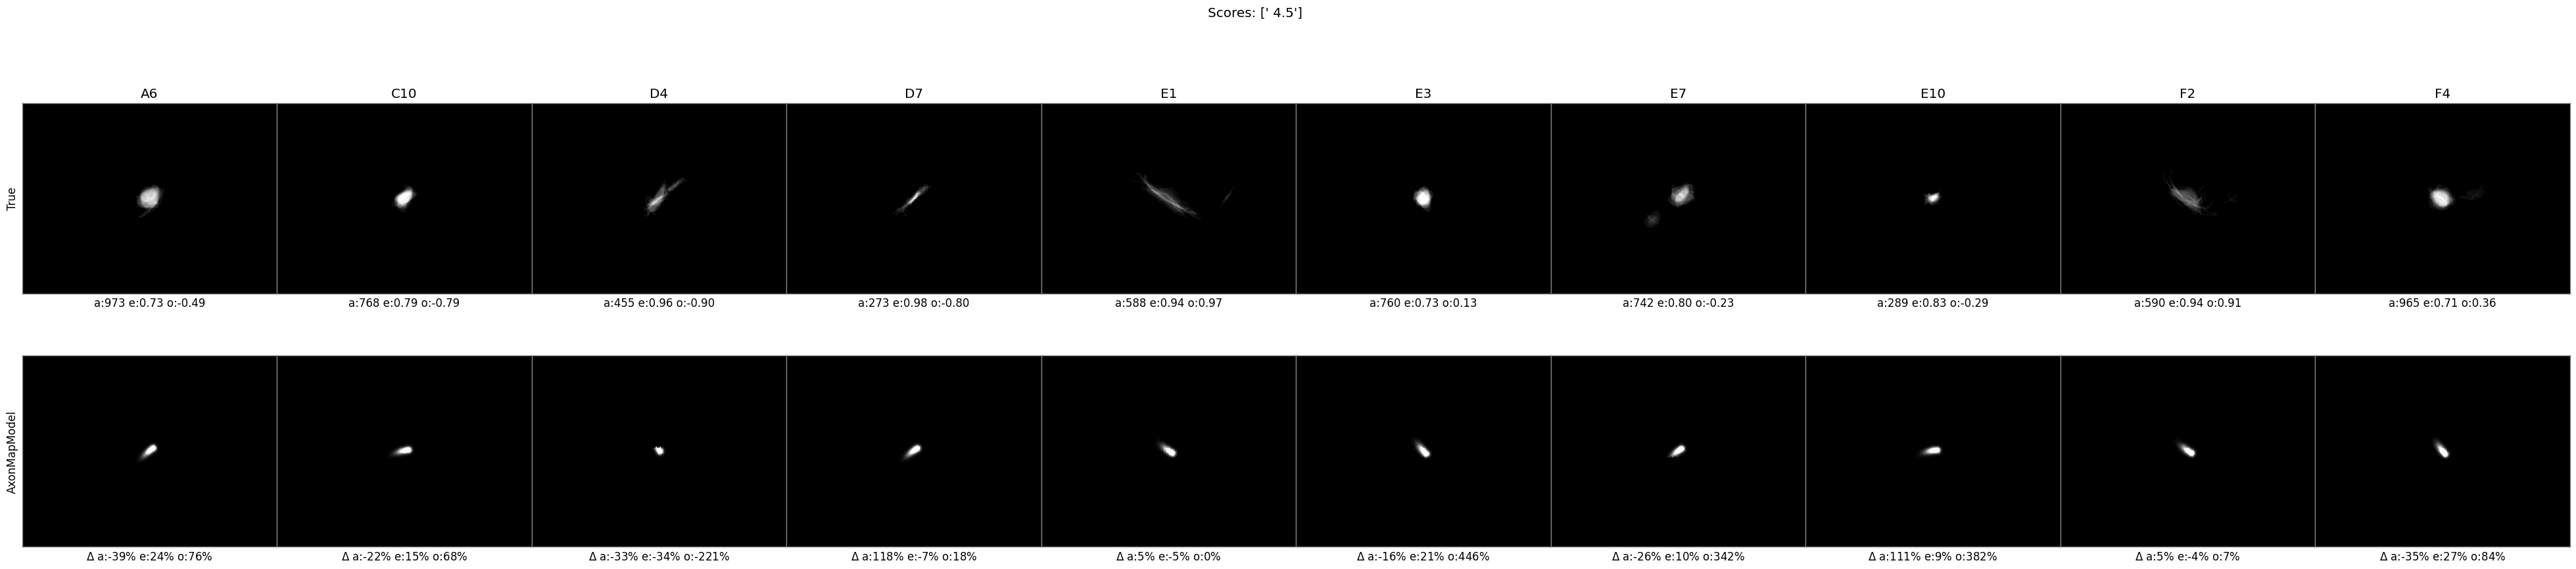

In [94]:
res = beyeler2019_eval(subject, implant, model)
print(res.results)
plot_beyeler_percepts(res)

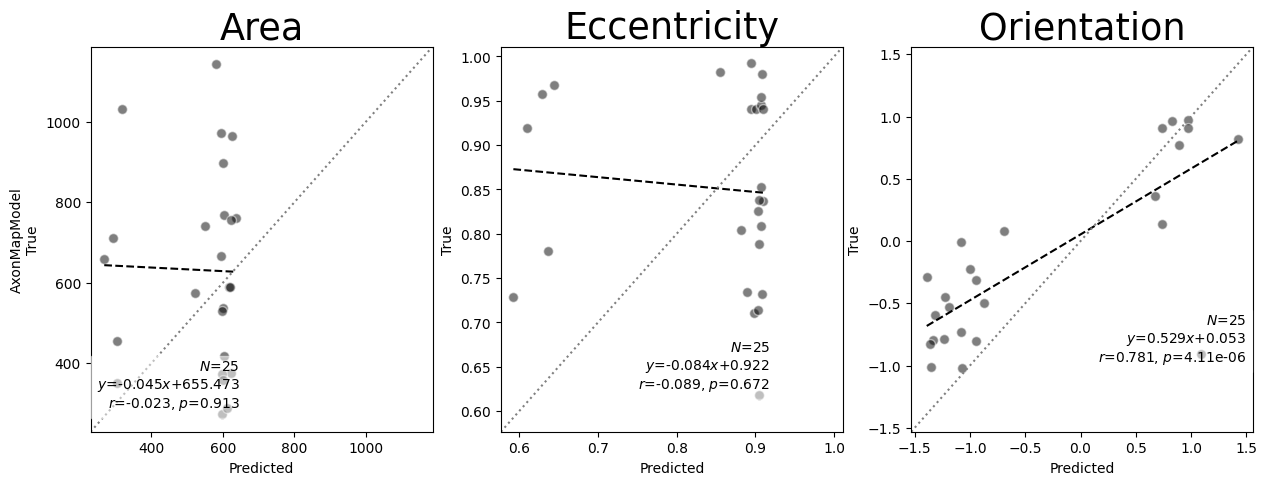

In [6]:
plot_beyeler_props(res)

In [112]:
subject = '12-005'
implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
model.rho = 100
model.axlambda = 585
model.build()
res = beyeler2019_eval(subject, implant, model)
print(res.results)

{'beyeler2019': {'score': 2.781201958656311, 'r2_scores': array([-0.669, -1.497,  0.385]), 'time': 0.21671247482299805}}


In [113]:
from scipy.optimize import minimize, differential_evolution

In [6]:

def opt_fn(params, subject='12-005'):
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
    model.rho = params[0]
    model.axlambda = params[1]
    model.build()
    res = beyeler2019_eval(subject, implant, model, data=data)
    print(f"{res.results['beyeler2019']['score'] : .3f}")
    return res.results['beyeler2019']['score']

In [22]:
opt = minimize(opt_fn, [100, 585])

1.6189283461406982
1.6189283461406982
1.6189283461406982


In [24]:
opt

      fun: 1.6189283461406982
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([100., 585.])

In [16]:
def cb(xk, convergence=0.0):
    print(xk, convergence)

In [ ]:
opts = []
for subject in ['12-005', '52-001', '51-009']:
    data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
    def opt_fn(params):
        implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
        model.rho = params[0]
        model.axlambda = params[1]
        model.build()
        res = beyeler2019_eval(subject, implant, model, data=data)
        print(f"{res.results['beyeler2019']['score'] : .3f}")
        return res.results['beyeler2019']['score']
    opt = differential_evolution(opt_fn, [(20, 600), (25, 2000)], x0=[100, 585])
    opts.append(opt)
    print('---------------------------------------------------')

 2.781
 21.328
 350.469
 33.898
 64.829
 50.804
 711.469
 68.328
 4.828
 2.961
 4.812
 742.461
 627.223
 25.416
 169.398
 382.888
 83.475
 3.936
 90.647
 1000.599
 4.447
 972.098
 288.768
 4.055
 72.844
 367.337
 21.005
 572.933
 36.947
 19.603
 3.060
 99.405
 6.286
 71.993
 3.583
 2.947
 11.412
 23.106
 105.789
 4.139
 6.021
 420.661
 15.788
 53.112
 9.524
 86.696
 11.578
 55.632
 117.338
 10.643
 40.744
 684.404
 5.439
 287.872
 3.712
 40.421
 3.515
 22.857
 3.070
 2.756
 11.911
 173.568
 23.956
 6.327
 6.678
 40.435
 3.306
 6.681
 9.324
 17.346
 50.439
 7.568
 106.788
 14.149
 9.588
 4.032
 34.523
 72.050
 5.201
 27.530
 15.236
 3.008
 3.338
 6.533
 9.230
 38.344
 5.804
 3.957
 6.121
 3.375
 3.471
 86.270
 3.638
 23.230
 10.590
 4.679
 13.188
 2.923
 4.164
 5.669
 3.339
 162.255
 18.843
 3.199
 4.418
 2.562
 4.501
 13.774
 7.659
 3.977
 3.636
 3.106
 4.807
 3.725
 7.834
 2.626
 4.228
 18.243
 2.737
 2.790
 2.509
 2.983
 38.815
 3.039
 24.483
 4.164
 3.969
 2.741
 3.727
 8.610
 2.977

In [ ]:
for opt in opts:
    print(opt)

In [9]:
for opt in opts:
    print(opt)

     fun: 1.5562400118520077
 message: 'Optimization terminated successfully.'
    nfev: 363
     nit: 11
 success: True
       x: array([119.72, 445.85])
     fun: 1.272087339997398
 message: 'Optimization terminated successfully.'
    nfev: 243
     nit: 7
 success: True
       x: array([ 157.63, 1249.21])
     fun: 2.3529348872724247
 message: 'Optimization terminated successfully.'
    nfev: 543
     nit: 17
 success: True
       x: array([ 22.32, 881.84])


### Eval using all data

In [6]:
for subject in ['12-005', '52-001', '51-009']:
    data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
    model.build()
    res = beyeler2019_eval(subject, implant, model, data=data, test_amps=None)
    print((subject, model.rho, model.axlambda))
    print(res.results)

(120, 446)
{'beyeler2019': {'score': 1.763188548058004, 'r2_scores': array([-0.57, -1.47, -0.79]), 'time': 0.18421578407287598}}
(158, 1250)
{'beyeler2019': {'score': 1.3120534961657577, 'r2_scores': array([ 0.12, -0.33, -0.5 ]), 'time': 0.3957254886627197}}
(22, 882)
{'beyeler2019': {'score': 2.9631100927224616, 'r2_scores': array([ 2.07e-03, -1.57e+01, -6.22e-01]), 'time': 0.40395545959472656}}


## Multivariate Gaussian Model

In [104]:
from pulse2percept.models import MVGModel
matplotlib.rcParams.update({'font.size': 12})

<Axes: xlabel='x (microns)', ylabel='y (microns)'>

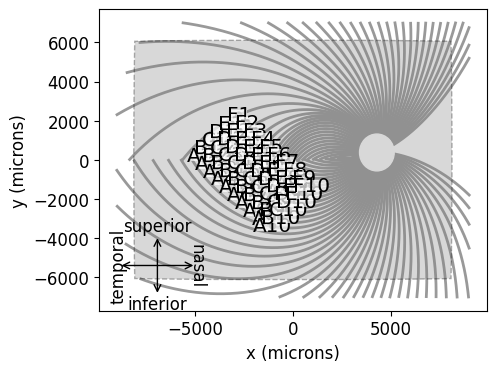

In [105]:
subject = '12-005'
implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False, model=MVGModel())
model.eta = 0.95
model.build()
model.plot(figsize=(5, 5))
implant.plot(annotate=True)

### Verify props line up

In [106]:
subject = '12-005'
implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False, model=MVGModel())
model.rho = 500
model.eta = 0.8
model.build()

MVGModel(ax_segments_range=(0, 50), axlambda=446, 
         axon_pickle='axons.pickle', 
         axons_range=(-180, 180), engine=None, eta=0.8, 
         eye='RE', grid_type='rectangular', 
         ignore_pickle=False, loc_od=(15.8, 1.4), 
         min_ax_sensitivity=0.001, n_ax_segments=500, 
         n_axons=1000, n_gray=None, n_jobs=1, n_threads=24, 
         noise=None, retinotopy=Watson2014Map, rho=500, 
         scheduler='threading', spatial=MVGSpatial, 
         temporal=None, thresh_percept=0.1353352832366127, 
         verbose=True, xrange=(-30, 30), xystep=0.25, 
         yrange=(-22.5, 22.5))

Bundle Tangent: [0.173]
[499.0, 0.8002521066014681, -1.4043713930056498]


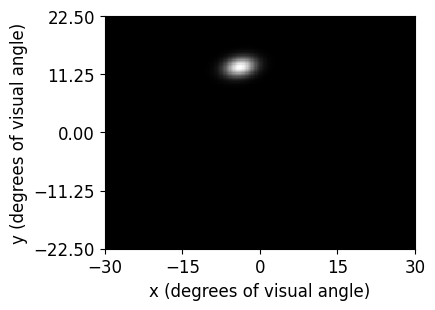

In [107]:
elec = 'A10'
print(f"Bundle Tangent: {model.calc_bundle_tangent_fast(implant.electrodes[elec].x, implant.electrodes[elec].y)}")
implant.stim = {'A10' : 1}
p = model.predict_percept(implant)
p.plot(figsize=(4, 4))
props = measure.regionprops(measure.label(p.max(axis='frames') > 1 / np.exp(1)**2))
prop = max(props, key = lambda x : x.area)
print([prop.area, prop.eccentricity, prop.orientation])

### Optimize

In [108]:
subject = '12-005'
implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False, model=MVGModel())
areas = []
eccs = []
data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
data = data[data.subject == subject]
data = data[data.amp1.isin([2.])]
for elec in data.electrode1.unique():
    dfelec = data[data.electrode1 == elec]
    ars = []
    ecs = []
    for img in dfelec.image:
        # im = resize(img, model.grid.shape)
        try:
            prop = max(measure.regionprops(measure.label(img > 1 / np.exp(1)**2)), key = lambda x : x.area)
            ars.append(prop.area)
            ecs.append(prop.eccentricity)
        except:
            ars.append(0)
            ecs.append(0.25)
            print(elec)
    areas.append(np.mean(ars))
    eccs.append(np.mean(ecs))
print(np.mean(areas))
print(np.mean(eccs))

631.3726666666666
0.8517459020804675


In [109]:
model.rho = np.mean(areas) / (384*512 / (181*241)) # rescale to account for differing sizes between img_shape and model.grid.shape
model.eta = np.mean(eccs)
model.build()

MVGModel(ax_segments_range=(0, 50), axlambda=446, 
         axon_pickle='axons.pickle', 
         axons_range=(-180, 180), engine=None, 
         eta=0.8517459020804675, eye='RE', 
         grid_type='rectangular', ignore_pickle=False, 
         loc_od=(15.8, 1.4), min_ax_sensitivity=0.001, 
         n_ax_segments=500, n_axons=1000, n_gray=None, 
         n_jobs=1, n_threads=24, noise=None, 
         retinotopy=Watson2014Map, rho=140.0813145582411, 
         scheduler='threading', spatial=MVGSpatial, 
         temporal=None, thresh_percept=0.1353352832366127, 
         verbose=True, xrange=(-30, 30), xystep=0.25, 
         yrange=(-22.5, 22.5))

{'beyeler2019': {'score': 0.6480121612548828, 'r2_scores': array([ 0.006, -0.002,  0.347]), 'time': 2.2909157276153564}}


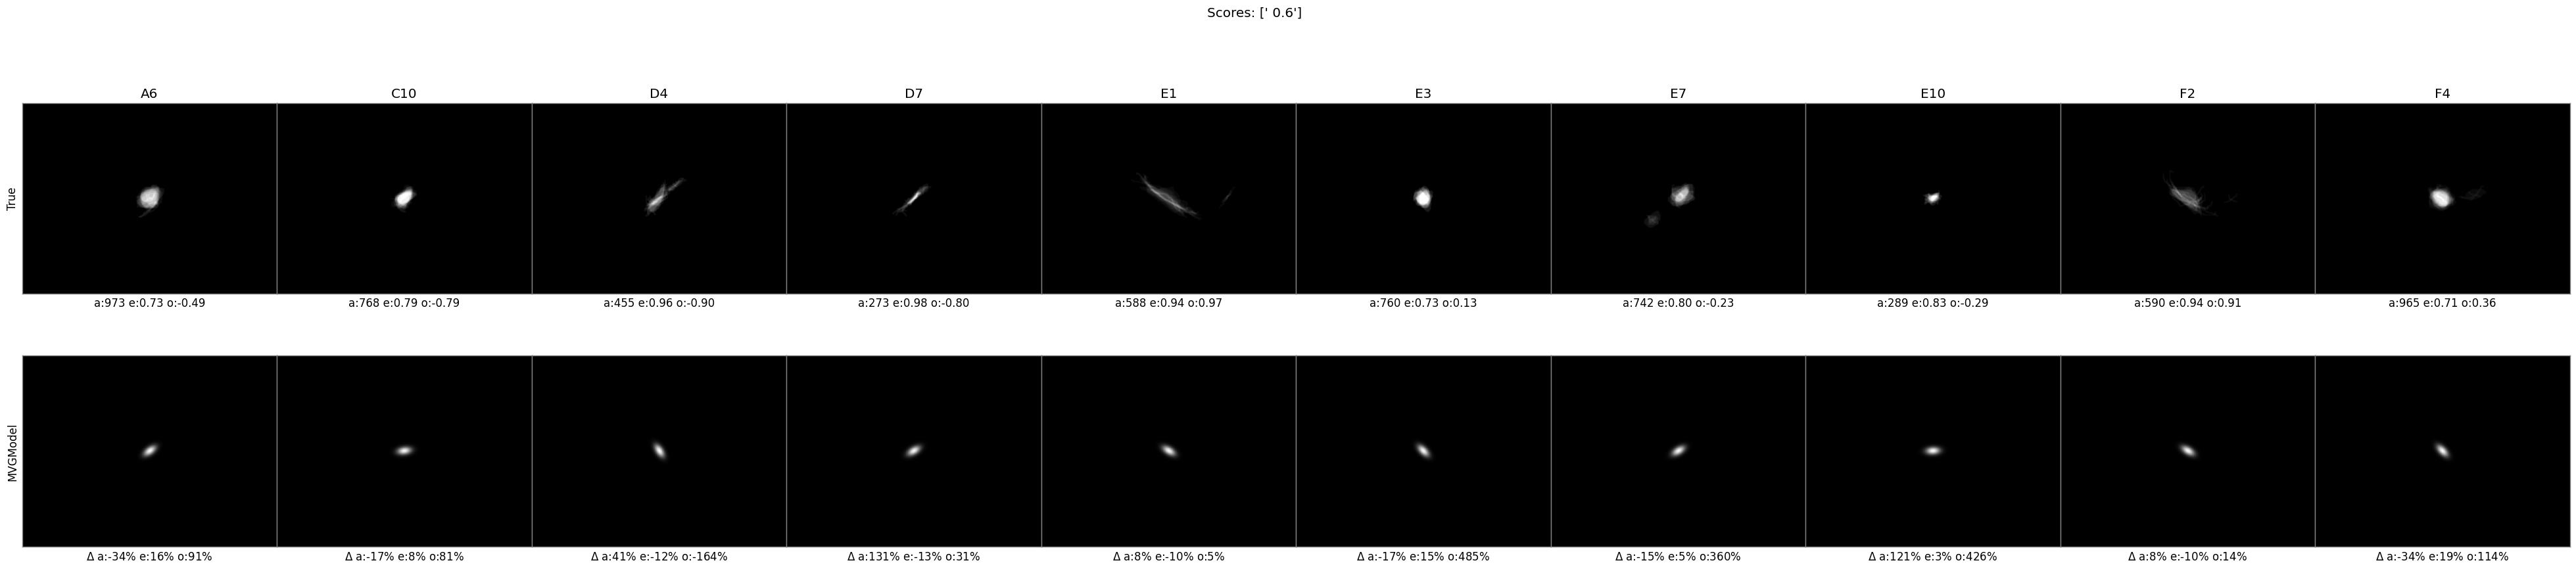

In [110]:
matplotlib.rcParams.update({'font.size': 12})
res = beyeler2019_eval(subject, implant, model)
print(res.results)
plot_beyeler_percepts(res)

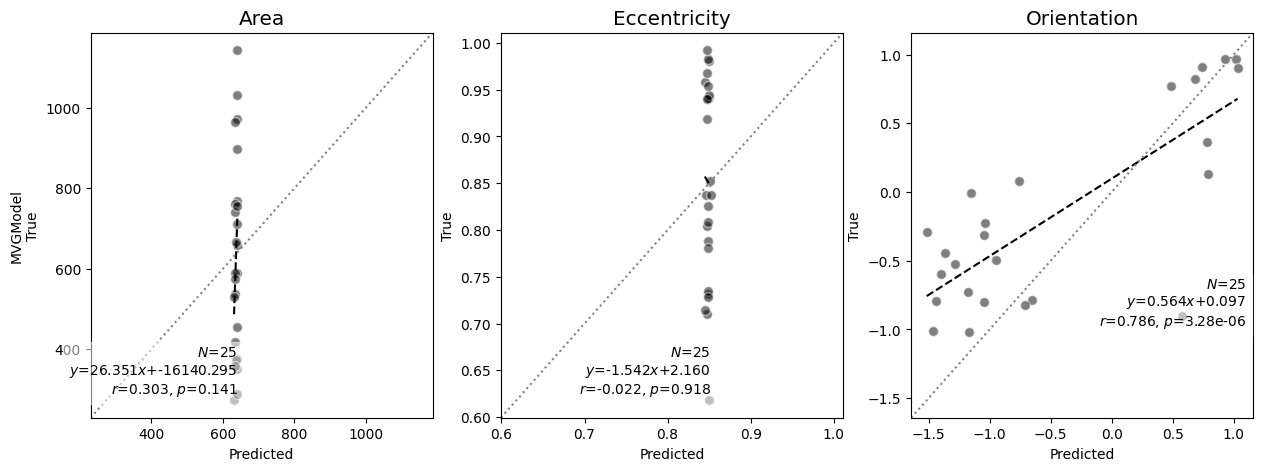

In [111]:
plot_beyeler_props(res)

### Optimize (scipy)

In [14]:
from scipy.optimize import differential_evolution
def opt_fn(params, subject='12-005'):
    model = MVGModel()
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False, model=model)
    model.rho = params[0]
    model.eta = params[1]
    model.build()
    res = beyeler2019_eval(subject, implant, model, data=data)
    print(f"{res.results['beyeler2019']['score'] : .3f}")
    return res.results['beyeler2019']['score']

In [17]:
opts = []
for subject in ['12-005', '52-001', '51-009']:
    data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
    def opt_fn(params, subject='12-005'):
        model = MVGModel()
        implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False, model=model)
        model.rho = params[0]
        model.eta = params[1]
        model.build()
        res = beyeler2019_eval(subject, implant, model, data=data)
        print(f"{model.rho :.1f}, {model.eta :.3f}, {res.results['beyeler2019']['score'] : .3f}")
        return res.results['beyeler2019']['score']
    opt = differential_evolution(opt_fn, [(20, 1000), (0, 1)], x0=[data.area.mean(), data.eccentricity.mean()])
    opts.append(opt)
    print('---------------------------------------------------')

560.2, 0.868,  4.195
410.0, 0.509,  3.684
193.5, 0.212,  3.729
944.3, 0.593,  5.482
507.1, 0.834,  3.939
714.6, 0.375,  4.952
862.4, 0.818,  5.246
317.8, 0.016,  4.228
667.0, 0.135,  5.005
100.8, 0.461,  2.871
929.8, 0.412,  5.495
890.5, 0.979,  5.332
35.2, 0.249,  3.724
58.2, 0.186,  3.795
828.7, 0.600,  5.184
683.7, 0.870,  4.690
764.0, 0.748,  4.965
530.7, 0.950,  4.073
354.5, 0.909,  2.988
605.6, 0.681,  4.422
573.3, 0.545,  4.366
257.3, 0.053,  4.140
798.4, 0.081,  5.356
132.0, 0.471,  2.792
471.5, 0.361,  4.160
229.9, 0.116,  4.002
438.6, 0.796,  3.563
632.1, 0.706,  4.517
286.8, 0.329,  3.570
182.0, 0.647,  2.010
43.7, 0.245,  3.751
103.6, 0.793,  1.331
193.5, 0.107,  3.957
291.2, 0.593,  2.852
338.1, 0.834,  2.841
780.5, 0.438,  5.107
862.4, 0.581,  5.279
360.6, 0.691,  3.128
742.3, 0.208,  5.135
394.1, 0.837,  3.264
77.5, 0.624,  2.238
75.4, 0.868,  1.477
184.6, 0.759,  1.508
58.2, 0.912,  1.705
602.8, 0.540,  4.482
197.8, 0.870,  1.436
112.6, 0.456,  2.842
58.0, 0.668,  2.163

ValueError: Some entries in x0 lay outside the specified bounds

### Extensions (e.g. modulate area/orient with angle/ecc)

# Granley